In [1]:
%matplotlib inline


ROI-based decoding analysis in Haxby et al. dataset
=====================================================

In this script we reproduce the data analysis conducted by
Haxby et al. in "Distributed and Overlapping Representations of Faces and
Objects in Ventral Temporal Cortex".

Specifically, we look at decoding accuracy for different objects in
three different masks: the full ventral stream (mask_vt), the house
selective areas (mask_house) and the face selective areas (mask_face),
that have been defined via a standard GLM-based analysis.




First we load and prepare the data
-----------------------------------
Fetch data using nilearn dataset fetcher



In [2]:
from nilearn import datasets
# by default we fetch 2nd subject data for analysis
haxby_dataset = datasets.fetch_haxby()
func_filename = haxby_dataset.func[0]

# Print basic information on the dataset
print('First subject anatomical nifti image (3D) located is at: %s' %
      haxby_dataset.anat[0])
print('First subject functional nifti image (4D) is located at: %s' %
      func_filename)

# Load nilearn NiftiMasker, the practical masking and unmasking tool
from nilearn.input_data import NiftiMasker

# load labels
import pandas as pd
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
stimuli = labels['labels']
# identify resting state labels in order to be able to remove them
task_mask = (stimuli != 'rest')

# find names of remaining active labels
categories = stimuli[task_mask].unique()

# extract tags indicating to which acquisition run a tag belongs
session_labels = labels["chunks"][task_mask]

/Users/Ralf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First subject anatomical nifti image (3D) located is at: /Users/Ralf/nilearn_data/haxby2001/subj2/anat.nii.gz
First subject functional nifti image (4D) is located at: /Users/Ralf/nilearn_data/haxby2001/subj2/bold.nii.gz


In [3]:
haxby_dataset.anat[0]

'/Users/Ralf/nilearn_data/haxby2001/subj2/anat.nii.gz'

Then we use scikit-learn for decoding on the different masks
-------------------------------------------------------------
The classifier: a support vector classifier



In [4]:
from sklearn.svm import SVC
classifier = SVC(C=1., kernel="linear")

# A classifier to set the chance level
from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier()

# Make a data splitting object for cross validation
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score
cv = LeaveOneLabelOut(session_labels)

mask_names = ['mask_vt', 'mask_face', 'mask_house']

mask_scores = {}
mask_chance_scores = {}

for mask_name in mask_names:
    print("Working on mask %s" % mask_name)
    # For decoding, standardizing is often very important
    mask_filename = haxby_dataset[mask_name][0]
    masker = NiftiMasker(mask_img=mask_filename, standardize=True)
    masked_timecourses = masker.fit_transform(
        func_filename)[task_mask]

    mask_scores[mask_name] = {}
    mask_chance_scores[mask_name] = {}

    for category in categories:
        print("Processing %s %s" % (mask_name, category))
        classification_target = (stimuli[task_mask] == category)
        mask_scores[mask_name][category] = cross_val_score(
            classifier,
            masked_timecourses,
            classification_target,
            cv=cv, scoring="roc_auc")

        mask_chance_scores[mask_name][category] = cross_val_score(
            dummy_classifier,
            masked_timecourses,
            classification_target,
            cv=cv, scoring="roc_auc")

        print("Scores: %1.2f +- %1.2f" % (
            mask_scores[mask_name][category].mean(),
            mask_scores[mask_name][category].std()))

/Users/Ralf/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Working on mask mask_vt
Processing mask_vt scissors
Scores: 0.90 +- 0.08
Processing mask_vt face
Scores: 0.97 +- 0.03
Processing mask_vt cat
Scores: 0.96 +- 0.03
Processing mask_vt shoe
Scores: 0.94 +- 0.07
Processing mask_vt house
Scores: 1.00 +- 0.00
Processing mask_vt scrambledpix
Scores: 1.00 +- 0.00
Processing mask_vt bottle
Scores: 0.90 +- 0.07
Processing mask_vt chair
Scores: 0.94 +- 0.03
Working on mask mask_face
Processing mask_face scissors
Scores: 0.67 +- 0.15
Processing mask_face face
Scores: 0.88 +- 0.07
Processing mask_face cat
Scores: 0.68 +- 0.14
Processing mask_face shoe
Scores: 0.64 +- 0.14
Processing mask_face house
Scores: 0.71 +- 0.14
Processing mask_face scrambledpix
Scores: 0.86 +- 0.12
Processing mask_face bottle
Scores: 0.45 +- 0.19
Processing mask_face chair
Scores: 0.53 +- 0.16
Working on mask mask_house
Processing mask_house scissors
Scores: 0.82 +- 0.10
Processing mask_house face
Scores: 0.84 +- 0.09
Processing mask_house cat
Scores: 0.80 +- 0.10
Processing

We make a simple bar plot to summarize the results
---------------------------------------------------



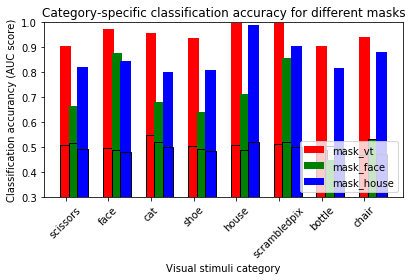

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure()

tick_position = np.arange(len(categories))
plt.xticks(tick_position, categories, rotation=45)

for color, mask_name in zip('rgb', mask_names):
    score_means = [mask_scores[mask_name][category].mean()
                   for category in categories]
    plt.bar(tick_position, score_means, label=mask_name,
            width=.25, color=color)

    score_chance = [mask_chance_scores[mask_name][category].mean()
                    for category in categories]
    plt.bar(tick_position, score_chance,
            width=.25, edgecolor='k', facecolor='none')

    tick_position = tick_position + .2

plt.ylabel('Classification accurancy (AUC score)')
plt.xlabel('Visual stimuli category')
plt.ylim(0.3, 1)
plt.legend(loc='lower right')
plt.title('Category-specific classification accuracy for different masks')
plt.tight_layout()


plt.show()